### start

In [1]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.workflow_orchestrator as wo
import sage_wallet_insights.model_evaluation as sime
import sage_utils.config_validation as ucv

# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    wm, wo,
    sime,
    ucv,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        # 'sage_wallet_insights',
        'sage_wallet_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/jeremymeadow/Library/Application Support/sagemaker/config.yaml


[21/Jul/25 13:07:34] INFO [utils.export_code:1659] Consolidation complete. All files are saved in temp/sagemaker_code.py
[21/Jul/25 13:07:34] MILESTONE [863424031.<module>:125] Good morning, let's get to work


# Modeling and Scoring

### Initiate orchestrator

In [5]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231107',
    '240306',
    '250301',
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config)

### Load, preprocess, and upload data

#### load data

In [6]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch.load_all_training_data(date_suffixes)

[21/Jul/25 13:08:00] MILESTONE [workflow_orchestrator.load_all_training_data:115] <PROD> Loading training data for 3 periods: ['231107', '240306', '250301']
[21/Jul/25 13:08:01] INFO [workflow_orchestrator.load_all_training_data:131] Training data loaded successfully: 656,500 total rows and 9 offsets for each date_suffix.


##### inspect features

In [ ]:
# # Create combined NaN count and describe statistics
# nan_counts = workflow_orch.training_data['x_train'].isna().sum()
# describe_stats = workflow_orch.training_data['x_train'].describe().T

# # Combine into single DataFrame
# combined_stats = pd.concat([
#     nan_counts.rename('nan_count'),
#     describe_stats
# ], axis=1).sort_index()

# u.display_full(combined_stats.sort_index())

#### preprocess data

In [7]:
workflow_orch.preprocess_all_training_data()

[21/Jul/25 13:08:02] INFO [workflow_orchestrator.preprocess_all_training_data:162] Preprocessing 3 date periods...
[21/Jul/25 13:08:02] INFO [wallet_preprocessor.preprocess_training_data:66] Starting preprocessing for SageMaker XGBoost compatibility...
[21/Jul/25 13:08:02] INFO [wallet_preprocessor._handle_missing_values:216] Filled NaN values in 100 columns for x_train.
[21/Jul/25 13:08:02] INFO [wallet_preprocessor._combine_x_y_data:313] Merged y df with target var cw_crypto_net_gain/crypto_inflows/winsorized with X data.
[21/Jul/25 13:08:02] INFO [wallet_preprocessor._save_preprocessed_df:358] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_897_td_column_ordering_v1/train_preprocessed_231107.parquet
[21/Jul/25 13:08:02] INFO [wallet_preprocessor.preprocess_training_data:104] Preprocessed train: 23,743 rows × 222 cols.
[21/Jul/25 13:08:02] INFO [wallet_preprocessor._handle_missing_values:216] Filled NaN values in 100 columns for x_test.
[21/Jul/2

{'231107': {'train':                                  cw_crypto_net_gain/crypto_inflows/winsorized  \
  wallet_address epoch_start_date                                                 
  3086611718     2023-03-12                                      0.304884910583   
  3007558824     2023-10-08                                     0.0420105233788   
  3055102018     2023-10-08                                     -0.115330629051   
  3065057146     2023-01-11                                      0.427110284567   
  3104363040     2023-11-07                                      0.131501197815   
  ...                                                                       ...   
  3022059626     2023-01-11                                       0.21764460206   
  3085874552     2023-11-07                                      0.126040607691   
  3048579738     2023-11-07                                      0.200386866927   
  3050690749     2023-08-09                                    -0.02

In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
preprocessed_data = preprocessor.preprocess_training_data(workflow_orch.training_data)

[21/Jul/25 12:30:57] INFO [wallet_preprocessor.preprocess_training_data:51] Starting preprocessing for SageMaker XGBoost compatibility...
[21/Jul/25 12:30:57] INFO [wallet_preprocessor._handle_missing_values:198] Filled NaN values in 100 columns for x_train.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor._combine_x_y_data:295] Merged y df with target var cw_crypto_net_gain/crypto_inflows/winsorized with X data.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor.preprocess_training_data:86] Preprocessed train: 172,106 rows × 222 cols.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor._handle_missing_values:198] Filled NaN values in 100 columns for x_test.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor._combine_x_y_data:295] Merged y df with target var cw_crypto_net_gain/crypto_inflows/winsorized with X data.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor.preprocess_training_data:86] Preprocessed test: 32,272 rows × 222 cols.
[21/Jul/25 12:30:57] INFO [wallet_preprocessor._handle_missing_values

#### upload data

In [ ]:
# Upload and retrieve URIs
workflow_orch.upload_training_data(preprocessed_data, overwrite_existing=True)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

### Train Model

#### retrieve file uris

In [4]:
date_suffixes = [
    '231107',
    '240306'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config)

# Generate URIs for specific dates without any prior setup
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)
s3_uris

[16/Jul/25 22:04:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials


{'231107': {'train': 's3://wallet-training-data/training-data-preprocessed/dda-897/231107/train_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'test': 's3://wallet-training-data/training-data-preprocessed/dda-897/231107/test_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'eval': 's3://wallet-training-data/training-data-preprocessed/dda-897/231107/eval_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'val': 's3://wallet-training-data/training-data-preprocessed/dda-897/231107/val_cw_crypto_net_gain_crypto_inflows_winsorized.csv'},
 '240306': {'train': 's3://wallet-training-data/training-data-preprocessed/dda-897/240306/train_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'test': 's3://wallet-training-data/training-data-preprocessed/dda-897/240306/test_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'eval': 's3://wallet-training-data/training-data-preprocessed/dda-897/240306/eval_cw_crypto_net_gain_crypto_inflows_winsorized.csv',
  'val': 's3://wallet-training-d

#### train model

In [5]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = date_suffixes[1]

modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)



In [6]:
modeling_results = modeler.train_model()

[16/Jul/25 22:04:09] INFO [wallet_modeler.train_model:113] Starting SageMaker training...
[16/Jul/25 22:04:09] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[16/Jul/25 22:04:09] INFO [wallet_modeler.train_model:141] SageMaker XGBoost container: 246618743249.dkr.ecr.us-west-2.amazonaws.com/sagemaker-xgboost:1.7-1
[16/Jul/25 22:04:09] INFO [wallet_modeler.train_model:147] Container version tag: 1.7-1
[16/Jul/25 22:04:09] INFO [wallet_modeler.train_model:151] Requested framework version: 1.7-1
[16/Jul/25 22:04:14] INFO [wallet_modeler.train_model:205] Launching training job: wallet-xgb-dda-897-240306-20250716-220414
[16/Jul/25 22:04:14] INFO [wallet_modeler.train_model:206] Model output path: s3://wallet-training-data/sagemaker-models/dda-897/
[16/Jul/25 22:04:14] INFO [telemetry_logging.wrapper:92] SageMaker Python SDK will collect telemetry to help us better understand our user's needs, diagnose issues, and deliver additional features.
To opt out of telemetr

2025-07-17 05:04:15 Starting - Starting the training job...
2025-07-17 05:04:29 Starting - Preparing the instances for training...
2025-07-17 05:04:51 Downloading - Downloading input data...
2025-07-17 05:05:47 Downloading - Downloading the training image......
2025-07-17 05:06:38 Training - Training image download completed. Training in progress...[2025-07-17 05:06:42.940 ip-10-0-182-73.us-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-07-17 05:06:42.963 ip-10-0-182-73.us-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-07-17:05:06:43:INFO] Imported framework sagemaker_xgboost_container.training
[2025-07-17:05:06:43:INFO] Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
[2025-07-17:05:06:43:INFO] No GPUs detected (normal if no gpus installed)
[2025-07-17:05:06:43:INFO] Running XGBoost Sagemaker in algorithm mode
[2025-07-17:05:06:43:INFO] Determined 0 GPU(

[16/Jul/25 22:09:42] INFO [wallet_modeler.train_model:220] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-897/wallet-xgb-dda-897-240306-20250716-220414/output/model.tar.gz


### Score validation set

#### get existing model uri

In [2]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))



date_suffixes = [
    '231107',
    '240306'
]
date_suffix = date_suffixes[1]


modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix
)


model_metadata = modeler.load_existing_model()

[17/Jul/25 15:03:03] INFO [credentials.load:1352] Found credentials in shared credentials file: ~/.aws/credentials
[17/Jul/25 15:03:04] INFO [wallet_modeler.load_existing_model:299] Loaded most recent model (timestamp: 20250716-220414): s3://wallet-training-data/sagemaker-models/dda-897/wallet-xgb-dda-897-240306-20250716-220414/output/model.tar.gz


#### deploy endpoint for predictions

In [3]:
modeler.list_active_endpoints()

[17/Jul/25 15:03:05] INFO [wallet_modeler.list_active_endpoints:630] Active endpoints: ['xgboost-dda-897-20250717-145718']


['xgboost-dda-897-20250717-145718']

In [4]:
modeler.deploy_endpoint()

[17/Jul/25 15:03:05] INFO [wallet_modeler.list_active_endpoints:630] Active endpoints: ['xgboost-dda-897-20250717-145718']
[17/Jul/25 15:03:05] WARNING [wallet_modeler.deploy_endpoint:565] An existing active endpoint matches the deployment prefix: xgboost-dda-897-20250717-145718
[17/Jul/25 15:03:07] INFO [wallet_modeler.deploy_endpoint:573] Deployment cancelled by user; using existing endpoint.


'xgboost-dda-897-20250717-145718'

#### load and preprocess test/val dfs

In [5]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




(11998, 221)


(58092, 221)

In [8]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

[17/Jul/25 15:05:24] INFO [wallet_preprocessor._handle_missing_values:198] Filled NaN values in 100 columns for foo.
[17/Jul/25 15:05:24] INFO [wallet_preprocessor._handle_missing_values:198] Filled NaN values in 100 columns for foo.
[17/Jul/25 15:05:24] INFO [3612056770.<module>:5] Preprocessed X_test (11998, 221) and X_val (58092, 221).


#### predict

In [10]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

[17/Jul/25 15:05:37] INFO [wallet_modeler.predict_using_endpoint:507] Prediction preview: 11998 rows across 4.0 chunks (20.46MB estimated total size)
[17/Jul/25 15:05:40] INFO [wallet_modeler.predict_using_endpoint:516] Beginning endpoint predictions for 4.0 chunks...
/Users/jeremymeadow/DreamsData/.sage_venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[17/Jul/25 15:06:01] INFO [wallet_modeler._save_endpoint_predictions:708] Predictions saved to temp/endpoint_predictions/endpoint_y_pred_test_dda_897_td_column_ordering_v1_240306.csv
[17/Jul/25 15:06:01] INFO [wallet_modeler.predict_using_endpoint:540] Endpoint predictions completed successfully.
[17/Jul/25 15:06:01] INFO [wallet_modeler.predict_using_endpoint:507] Prediction preview: 58092 rows across 19.0 chunks (101.66MB estimated total size)
[17/Jul/25 15:06:

#### delete all endpoints

In [11]:
modeler.delete_all_endpoints()

[17/Jul/25 15:08:18] INFO [wallet_modeler.list_active_endpoints:630] Active endpoints: ['xgboost-dda-897-20250717-145718']
[17/Jul/25 15:08:18] INFO [wallet_modeler.delete_endpoint:656] Deleting endpoint: xgboost-dda-897-20250717-145718
[17/Jul/25 15:08:18] INFO [wallet_modeler.delete_endpoint:658] Successfully deleted endpoint: xgboost-dda-897-20250717-145718


In [12]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

[17/Jul/25 15:08:19] INFO [wallet_modeler.list_active_endpoints:630] Active endpoints: []


[]

# Model Evaluation

### Analyze predictions

In [9]:

date_suffixes = [
    '231107',
    '240306'
]
date_suffix = date_suffixes[1]

[19/Jul/25 15:16:13] INFO [model_evaluation.summary_report:177] 
Model Performance Summary
Objective: reg:linear
Target: cw_crypto_net_gain/crypto_inflows/winsorized 
ID: sagemaker_dda_897_td_column_ordering_v1_240306
Test Samples:             11,998
Number of Features:       221
Features per Window:      54

Core Metrics
-----------------------------------
R² Score:                 0.655
RMSE:                     0.232
MAE:                      0.154

Validation Set Metrics
-----------------------------------
R² Score:                 -2.997
RMSE:                     0.329
MAE:                      0.274
Spearman ρ:               0.026
Top 1% Mean:              -0.118

Residuals Analysis
-----------------------------------
Mean of Residuals:        0.001
Std of Residuals:         0.232
95% Prediction Interval:  ±0.455


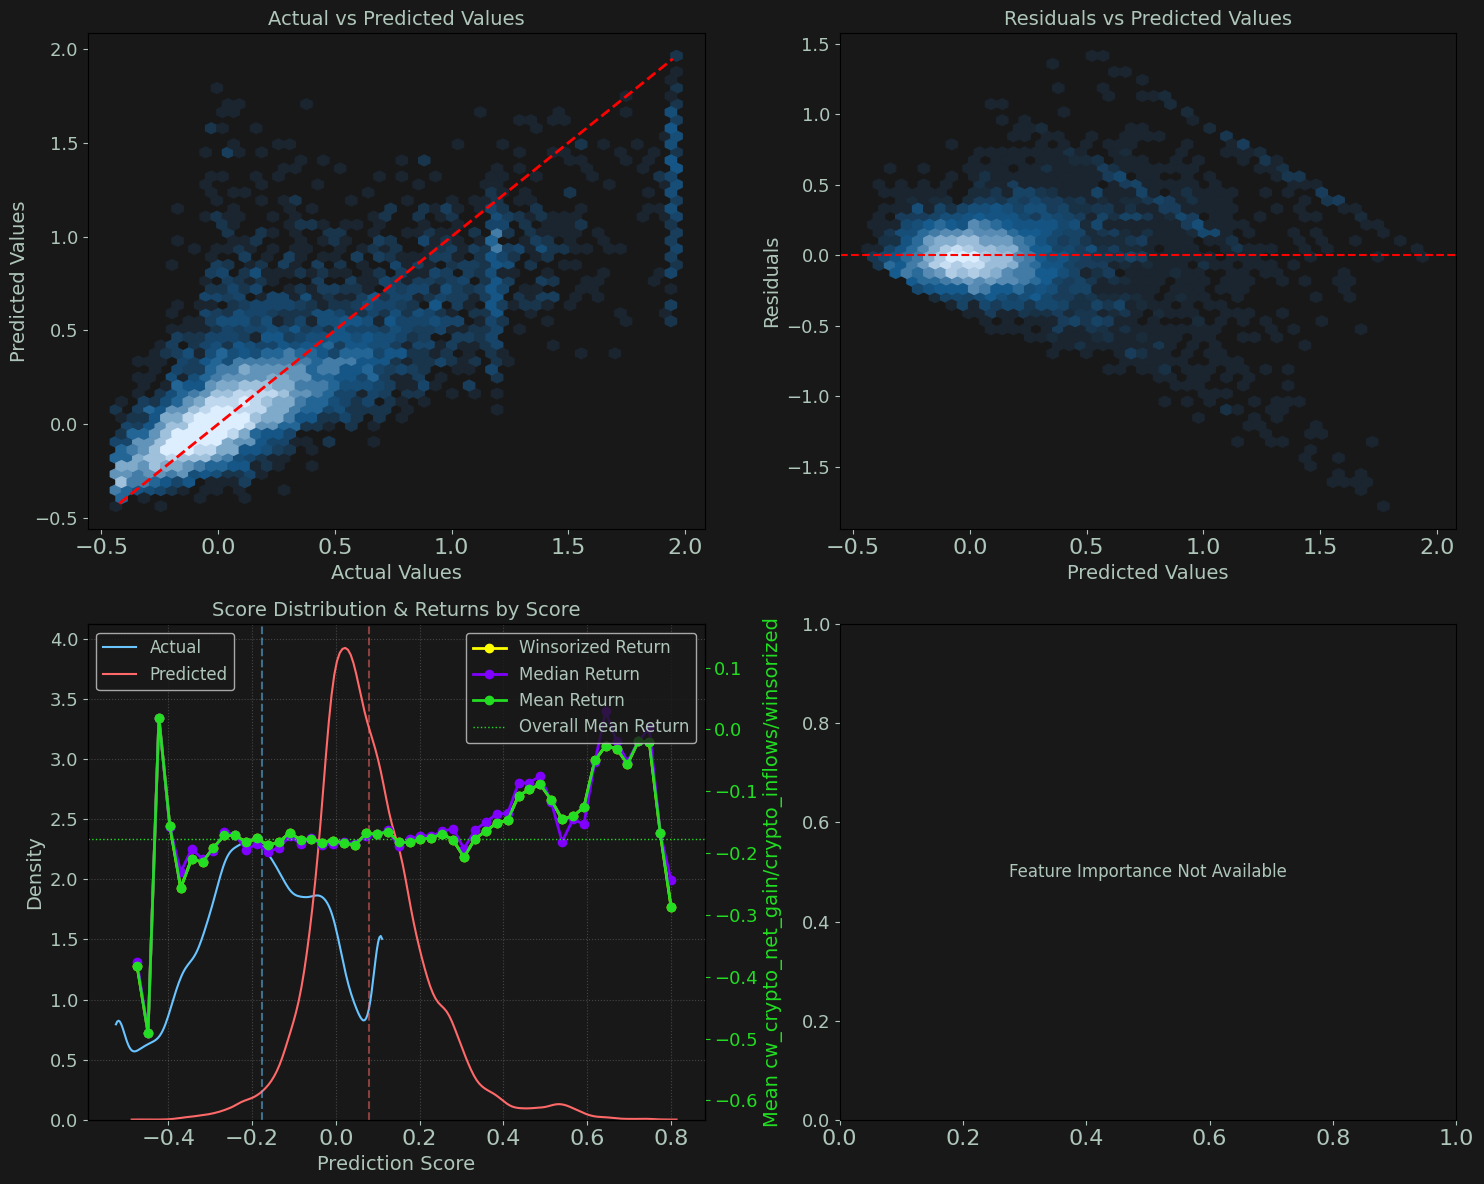

In [10]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [18]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

[17/Jul/25 15:16:01] INFO [model_evaluation.summary_report:177] 
Model Performance Summary
Objective: reg:linear
Target: cw_crypto_net_gain/crypto_inflows/winsorized 
ID: sagemaker_dda_897_td_column_ordering_v1_240306
Test Samples:             11,998
Number of Features:       221
Features per Window:      54

Core Metrics
-----------------------------------
R² Score:                 0.655
RMSE:                     0.232
MAE:                      0.154

Validation Set Metrics
-----------------------------------
R² Score:                 -2.997
RMSE:                     0.329
MAE:                      0.274
Spearman ρ:               0.026
Top 1% Mean:              -0.118

Residuals Analysis
-----------------------------------
Mean of Residuals:        0.001
Std of Residuals:         0.232
95% Prediction Interval:  ±0.455


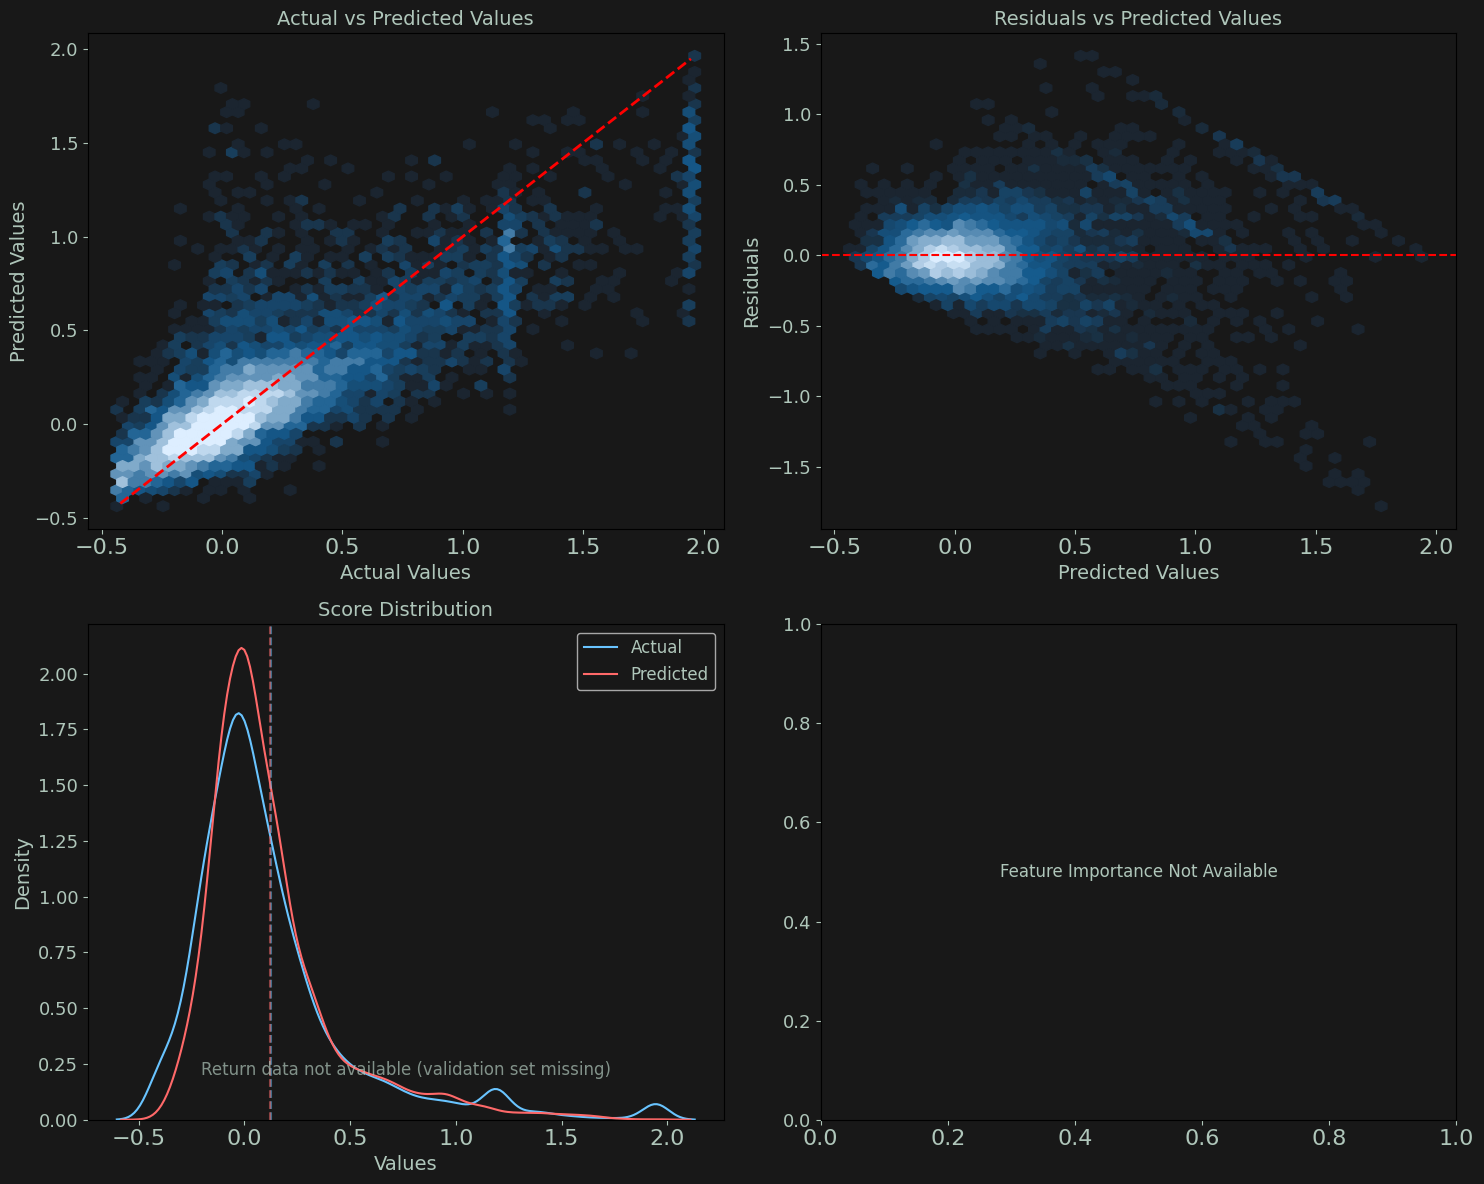

In [21]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

'regression'

In [ ]:
target_variable

'cw_crypto_net_gain/crypto_inflows/winsorized'